# Simulation of exponential negative chi-squared statistic in 2D

We perform simulation on the statistic
$$
    f_2(\Phi\mathcal{X}) = \sum_{s=1}^2 \exp\bigg( - \bigg( \frac{1}{\sqrt{n}k} \sum_{i=1}^n \sum_{j=1}^k (\phi_{ij} \textbf{X}_i)_s \bigg)^2 \bigg)
$$
where $(\cdot)_s$ indicates the $s$-th coordinate, under the model
$$
 \textbf{X}_i \overset{i.i.d.}{\sim} \mathcal{C} \bigg(\textbf{0}, \sigma^2 \begin{pmatrix} 1 & \rho \\ \rho & 1 \end{pmatrix} \bigg), \qquad \phi_{ij} \overset{i.i.d.}{\sim} \text{Uniform} \bigg\{ \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix},  \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix} \bigg)\;,
$$
and plot the standard deviation of $f_2$ and its confidence interval width against number of augmentations. For the standard deviation of $f_2$, the theoretical value as number of augmentations goes to infinity is computed in Lemma 36.

The shaded confidence region for the sample standard deviation of $f_2$ is computed using $\chi^2$ distribution. The confidence interval width for $f_2$ is estimated by fitting a $t$-distribution to the sample variance of $f_2$ (centred by sample mean), and the shaded confidence region for the confidence interval width is by performing the same transform to the confidence interval of the sample variance of centred $f_2$.

## Utility functions

In [8]:
import pickle as pk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patchs
import matplotlib.transforms as tfs
from matplotlib import colors
from scipy.stats import chi2, norm, multivariate_normal, t
                        
def var_formula_augmented(rho, sigs):
    return 4 / np.sqrt(1 + 2*(1+rho) * sigs) - 4 / (1 + (1+rho) * sigs)  

def ci_width_formula_augmented(rho, sigs, alpha=0.05):
    chi_ppf = np.array([chi2.ppf(alpha/2, 1), chi2.ppf(1-alpha/2, 1)])
    ci = 2 * np.exp(- (1+rho) * sigs * chi_ppf / 2)
    return np.abs(ci[1] - ci[0])

def var_formula_unaugmented(rho, sigs):
    return 2 / np.sqrt(  (1+2*sigs)**2 - rho**2 ) + 2 / np.sqrt(1+4*sigs) - 4 / (1+2*sigs)

def ci_width_formula_unaugmented_sim(rho, sigs, alpha=0.05, sim_num=10000, seed=1):
    xs = multivariate_normal.rvs(mean=np.array([0,0]), cov=sigs * np.array([[1, rho], [rho, 1]]), size=sim_num, random_state=seed)
    samples = [np.exp(-x[0]**2) + np.exp(-x[1]**2) for x in xs]
    var = np.var(samples, ddof=1)
    norm_ppf = np.array([norm.ppf(alpha/2), norm.ppf(1-alpha/2)])
    ci_width = (norm_ppf[1]-norm_ppf[0]) * np.sqrt(var)
    return ci_width

def sim_fn(sigs, rho, k, n):
    x_s = np.random.multivariate_normal( np.array([0, 0]) , sigs*np.array([[1, rho], [rho, 1]]), size=n )
    phi_ss = np.random.binomial( 1, 0.5, size=(n,k) )
    augmented_x_ss = [ [ (x if phi==0 else x[[1,0]]) for phi in phi_s ] for x, phi_s in zip(x_s, phi_ss) ]
    tmp = np.array([ np.sum([ [ augmented_x[0] for augmented_x in augmented_x_s ] for augmented_x_s in augmented_x_ss ]),
                               np.sum([ [ augmented_x[1] for augmented_x in augmented_x_s ] for augmented_x_s in augmented_x_ss ])])
    chi_statistic = tmp**2 / (n * (k**2))
    negexp_statistic = np.exp( - chi_statistic)
    negexpsum_statistic = np.sum(negexp_statistic)
   
    return negexpsum_statistic

def sim_vary_k(folder, n, sigs, rho, samples, k_range, seed=100):
    np.random.seed(seed)
    # simulation
    for k in k_range:
        print('    k ' + str(k) + '...                           ', end='\r')
        fname_str = 'sig' + str(sigs) + 'rho ' + '{:.2f}'.format(rho) + ' k-' + str(k) + ' n-' + str(n) 

        results = [sim_fn(sigs, rho, k, n) for s in range(samples)]
        
        negexpsum_statistic_samples = results

        with open(folder + '/negexpsum ' + fname_str + '.pk', 'wb+') as f:
            pk.dump(negexpsum_statistic_samples, f)

## Main simulation

In [ ]:
n = 100
samples = 10000
k_range = list(range(1,201))

In [9]:
folder = 'neg_exp_2D_sum/beneficial'
sigs = 1
rho = -0.5
sim_vary_k(folder, n, sigs, rho, samples, k_range)

In [10]:
folder = 'neg_exp_2D_sum/harmful' 
sigs = 9
rho = -0.5
sim_vary_k(folder, n, sigs, rho, samples, k_range)

## Plots

In [16]:
alpha=0.05
transparent_ratio = 0.5

file_prefix_list = [
    'neg_exp_2D_sum/beneficial/negexpsum sig1rho -0.50',
    'neg_exp_2D_sum/harmful/negexpsum sig9rho -0.50',
]

color_list = [
    'tab:blue',
    'tab:orange'
]

plt.rcParams.update({ 
    "text.usetex": True,
    "font.weight": "heavy",
    "font.size": 14,
    "text.latex.preamble": r"\usepackage{amsmath}"
})

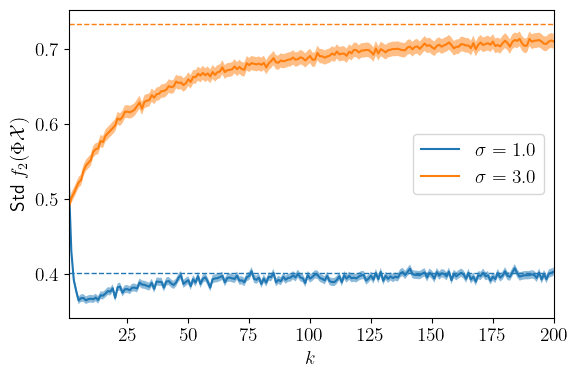

In [19]:
fig = plt.figure(figsize=(6, 4), dpi=100)

for file_prefix, color in zip(file_prefix_list, color_list):    
    std_list = []
    std_ci_list = []
    ci_width_list = []
    ci_width_ci_list = []
    for i, k in enumerate(k_range):
        fname_str = file_prefix + ' k-' + str(k) + ' n-' + str(n)
        with open(fname_str + '.pk', 'rb') as f:
            samples = pk.load(f)
        num = len(samples)
        std = np.std(samples, ddof=1)

        chi_ppf = np.array([chi2.ppf(1-alpha/2, num-1), chi2.ppf(alpha/2, num-1)])
        std_ci = np.sqrt((num-1) * (std**2) / chi_ppf)

        std_list.append(std)
        std_ci_list.append(std_ci)
    
    sigma = np.sqrt(float(file_prefix.split('sig')[1].split('rho')[0]))
    rho = float(file_prefix.split('rho ')[1].split(' ')[0])
    
    plt.plot(k_range, std_list, label=r'$\sigma=' + str(round(sigma, 0)) + '$', color=color) 
    fill_color = np.array(colors.to_rgba(color))
    fill_color[3] *= transparent_ratio
    plt.fill_between(k_range, [ci[0] for ci in std_ci_list], [ci[1] for ci in std_ci_list], facecolor=fill_color)
    
    pred_std = np.sqrt(var_formula_augmented(rho, sigma**2))
    plt.hlines(pred_std, k_range[0], k_range[-1], color, 'dashed', linewidth=1)
    
plt.legend()
    
plt.xlabel(r'$k$')
plt.ylabel(r'$\text{Std } f_2(\Phi \mathcal{X})$')
plt.xlim([1,200])

plt.tight_layout()
plt.savefig('fig3_simulation_expnegchi_2D_std.pdf', dpi=fig.dpi, bbox_inches='tight')

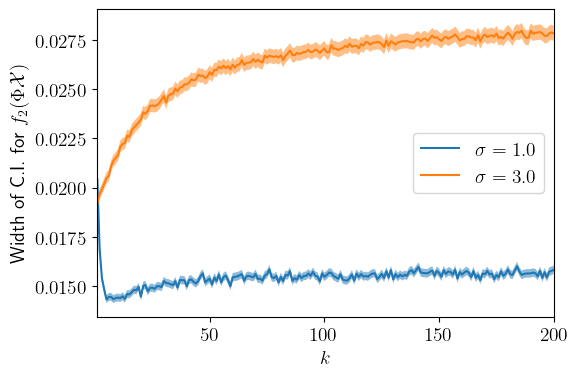

In [18]:
fig = plt.figure(figsize=(6, 4), dpi=100)

for file_prefix, color in zip(file_prefix_list, color_list):    
    std_list = []
    std_ci_list = []
    ci_width_list = []
    ci_width_ci_list = []
    for i, k in enumerate(k_range):
        fname_str = file_prefix + ' k-' + str(k) + ' n-' + str(n)
        with open(fname_str + '.pk', 'rb') as f:
            samples = pk.load(f)
            
        num = len(samples)
        std = np.std(samples, ddof=1)

        chi_ppf = np.array([chi2.ppf(1-alpha/2, num-1), chi2.ppf(alpha/2, num-1)])
        std_ci = np.sqrt((num-1) * (std**2) / chi_ppf)

        t_ppf = np.array([t.ppf(alpha/2, num-1), t.ppf(1-alpha/2, num-1)])
        ci_width = (t_ppf[1]-t_ppf[0]) * std / np.sqrt(num)
        ci_width_ci = (t_ppf[1]-t_ppf[0]) * std_ci / np.sqrt(num)

        ci_width_list.append(ci_width)
        ci_width_ci_list.append(ci_width_ci)
    
    sigma = np.sqrt(float(file_prefix.split('sig')[1].split('rho')[0]))
    rho = float(file_prefix.split('rho ')[1].split(' ')[0])
    
    plt.plot(k_range, ci_width_list, label=r'$\sigma=' + str(round(sigma, 0)) +'$', color=color) 
    fill_color = np.array(colors.to_rgba(color))
    fill_color[3] *= transparent_ratio
    plt.fill_between(k_range, [ci[0] for ci in ci_width_ci_list], [ci[1] for ci in ci_width_ci_list], facecolor=fill_color)

plt.legend()

plt.xlabel(r'$k$')
plt.ylabel(r'$\text{Width of C.I. for } f_2(\Phi \mathcal{X})$')
plt.xlim([1,200])

plt.tight_layout()
plt.savefig('fig3_simulation_expnegchi_2D_ci_width.pdf', dpi=fig.dpi, bbox_inches='tight')